## 신경망 학습

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

In [2]:
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+delta)) / batch_size

* 신경망에서의 기울기

In [3]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = (tmp_val + h)
        fxh1 = f(x)            # f(x+h)
        
        x[idx] = (tmp_val - h)
        fxh2 = f(x)            # f(x-h)
        
        grad[idx] = (fxh1-fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()
    return grad

* softmax

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


* sigmoid

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

* 2층 신경망 구현하기

In [11]:
class TwoLayerNet: # 신경망에서 사용할 메서드 정의
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # 값 너무 커지는거 방지하려고 std곱해줌
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x): # 예측: 입력과 가중치 곱의 합을 함수에 통과시키는 과정 
        # 예측 구하기(가중치의 합 > sigmoid 통과 > 가중치의 합 > softmax 통과)
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)

        a2 = np.dot(z1, W2) + b2 
        y = softmax(a2)
        return y
    
    def loss(self, x, t): # 예측과 정답의 차이
        # 손실(비용)힘수의 결과 구하기
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t): # 최종 예측에서는 softmax 통과할 필요없이 가장 큰 값만 찾아서 같은지 비교 
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        # 수치 미분(중앙차분)
        # 그레디언트(편미분의 벡터) 구하기
        loss_W = lambda W : self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1 = self.params['W1']
        W2 = self.params['W2']
        b1 = self.params['b1']
        b2 = self.params['b2']
        
        batch_size = t.shape[0]
        grads = {}
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        da2 = (y-t) / batch_size
        grads['W2'] = np.dot(z1.T, da2)
        grads['b2'] = np.sum(da2, axis=0)
        
        dz1 = np.dot(da2, W2.T)
        da1 = ((1-z1) * z1)* dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        
        return grads

In [12]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터 설정

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수(1에폭 당 600번)
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num): # 경사하강법
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    #grad = network.numerical_gradient(x_batch, t_batch) # 미분된 벡터
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'): # 경사하강법
        network.params[key] = network.params[key] - (learning_rate * grad[key])
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0: # 600의 배수일 때 출력
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09915, 0.1009
train acc, test acc | 0.7963166666666667, 0.8008
train acc, test acc | 0.8779333333333333, 0.8813
train acc, test acc | 0.8986833333333333, 0.9036
train acc, test acc | 0.9090333333333334, 0.9124
train acc, test acc | 0.91515, 0.92
train acc, test acc | 0.92045, 0.9247
train acc, test acc | 0.9249333333333334, 0.9282
train acc, test acc | 0.9285333333333333, 0.9304
train acc, test acc | 0.9317333333333333, 0.9342
train acc, test acc | 0.9347666666666666, 0.9354
train acc, test acc | 0.9373, 0.9385
train acc, test acc | 0.9394166666666667, 0.9402
train acc, test acc | 0.9423166666666667, 0.9411
train acc, test acc | 0.9429333333333333, 0.9416
train acc, test acc | 0.9459333333333333, 0.943
train acc, test acc | 0.9467666666666666, 0.9441


In [14]:
len(train_acc_list)

17

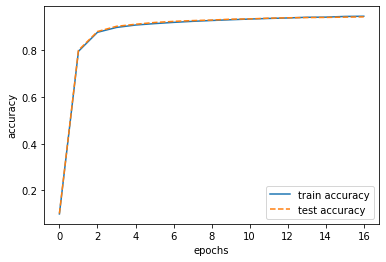

In [26]:
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train accuracy')
plt.plot(x, test_acc_list, label='test accuracy', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

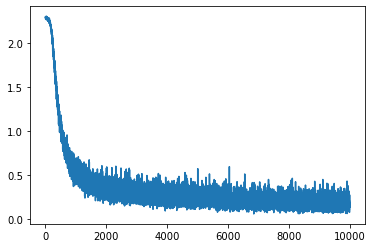

In [23]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)

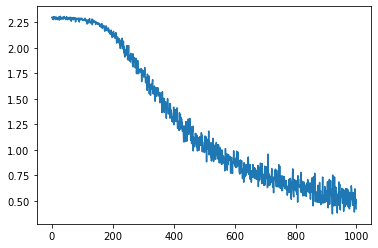

In [24]:
x = np.arange(len(train_loss_list)-9000)
plt.plot(x, train_loss_list[:1000])